In [1]:
# 9/30/19, Prof Spirling, Prof Jones-Rooy
# This notebook provides code which will be helpful for those completing HW2 in DS4E
# In general, only small changes should be required to answer the questions in the HW.

In [2]:
# let's import the datascience package, 
from datascience import *
# and numpy...
import numpy as np
# and matplotlib...
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots


In [3]:
# we will create a vector
vec =  np.array([1,3,9,7,5,2,12])
# we can take the median of this vector
percentile(50, vec)

5

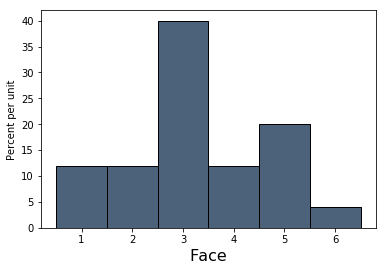

In [4]:
# let's follow the die rolling example from the textbook
# First we need to define the possible outcomes of the die roll
die = Table().with_column('Face', np.arange(1, 7, 1))

#this is a discrete random variable, so we need to define some "bins" 
# to take the "results" of the simulations below
die_bins = np.arange(0.5, 6.6, 1)

# now we will simulate 25 rolls and draw the histogram
# first, we have to define what the histogram is
def empirical_hist_die(n):
    die.sample(n).hist(bins = die_bins)
#then, we can do the simulation
empirical_hist_die(25)

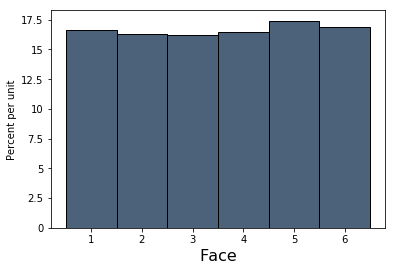

In [5]:
#to see the LLN at work, let's try 10000 simulations
empirical_hist_die(10000)
#what do we notice about the heights of the bins?

In [6]:
# Now we will sample from a population.
# The population in question is all the NYC employee salaries
nyc_salary_full = Table.read_table('nyc_population_salaries.csv')
# we can get the median base salary via
percentile(50, nyc_salary_full.column('Base.Salary'))
# we could also look at OT.Hours or any other variable for which a median makes sense

58850.0

In [7]:
# we can take the mean as well.  
# Do you expect it to be higher or lower than the median in this case?
np.mean(nyc_salary_full.column('Base.Salary'))

61869.070649128436

In [8]:
# let's take a sample from the NYC data (without replacement)
# and take the mean of Base Salary.  How close do we get to the population 
# mean?

#first let's take a sample of 20
sample_20 = nyc_salary_full.sample(20)
#second let's take a sample of 3000
sample_3000 = nyc_salary_full.sample(3000)

#"print" them out
print( np.mean(sample_20.column("Base.Salary")) )
print( np.mean(sample_3000.column("Base.Salary")) )
# which gets closer to the "truth" (population mean)?

61460.2
61624.92288


In [9]:
#####################################################################################
# We can simulate the mean's distribution: i.e. the sample distribution of the mean.#

# first we'll write a function that grabs a sample of size 2000 from our NYC salary population
# and then calculates the mean
def random_samp_mean():
    return np.mean(nyc_salary_full.sample(2000).column('Base.Salary'))

In [10]:
# next, we decide how many simulations we want, and we put those simulations into an array
# the contents of which we can look at later

# we will  have 600 simulations (takes a little while)
nsims = 600

our_means = make_array()

for i in np.arange(nsims):
    our_means = np.append(our_means, random_samp_mean())
    


In [11]:
# let's put all those means into a table
simulated_means = Table().with_column('Sample Mean', our_means)

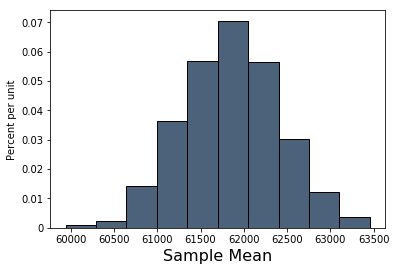

In [12]:
# and now we can produce the sampling distribution
simulated_means.hist()

In [13]:
# we can take the mean of these means, and see how close it comes to our population mean
np.mean(simulated_means.column('Sample Mean'))

61857.80213283334

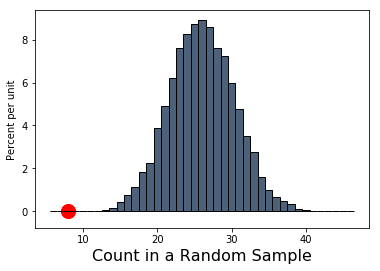

In [14]:
##########################################
# The Swain case as a simulation problem #

# in the original example, the eligible population was 0.26 Black, 0.74 white, proportionally
eligible_population = [0.26, 0.74]

# we define *one* simulated count as follows:
# this randomly generates 100 people according to the proportions of the eligible_population
# (remember, there were 100 people on a jury panel)
def one_simulated_count():
    return (100 * sample_proportions(100, eligible_population)).item(0) 

# we need an array to record all our simulations
counts = make_array()

# and we need to choose a certain (large) number of simulations
repetitions = 10000
for i in np.arange(repetitions):
    counts = np.append(counts, one_simulated_count())

#now we need to plot the relevant histogram, along with the Swain observed data
swain_observed = 8 #black men on the panel

Table().with_column(
    'Count in a Random Sample', counts
).hist(bins = np.arange(5.5, 46.6, 1))
plots.scatter(swain_observed, 0, color='red', s=200);

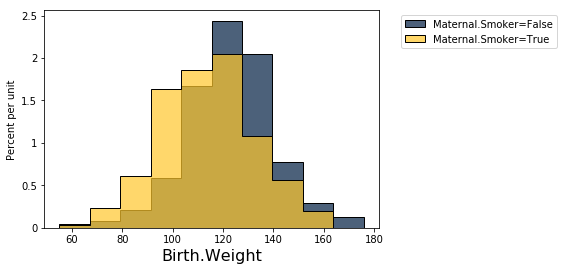

In [15]:
#######################################################
# do two sample hypothesis tests using the baby data  #

#get the data and plot the two groups: smokers vs non-smokers
births = Table.read_table('baby.csv')
smoking_and_birthweight = births.select('Maternal.Smoker', 'Birth.Weight')
smoking_and_birthweight.hist('Birth.Weight', group = 'Maternal.Smoker')

In [16]:
# get the averages 
means_table = smoking_and_birthweight.group('Maternal.Smoker', np.average)
means_table

Maternal.Smoker,Birth.Weight average
False,123.085
True,113.819


In [17]:
# obtain the observed diffeence between non-smokers (false) and smokers (true)
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference # this is the mean of the True minus the false

-9.266142572024918

In [18]:
# let's write a generic function to take the difference in means between two columns
def difference_of_means(table, label, group_label):
    reduced = table.select(label, group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)


In [19]:
# now we need a function to do permutation inference.
# this will give the difference in means between two groups formed by randomizing labels
#  This will produce the statistic under the "null" of no difference
def one_simulated_difference(table, label, group_label):
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
    return difference_of_means(shuffled_table, label, 'Shuffled Label')   
 

In [20]:
# create an array to take the results of differences 
differences = make_array()


In [21]:
# do a large number of simulations, say 4000
repetitions = 4000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference(births, 'Birth.Weight', 'Maternal.Smoker')
    differences = np.append(differences, new_difference)   

Text(0, 0.5, 'n cases')

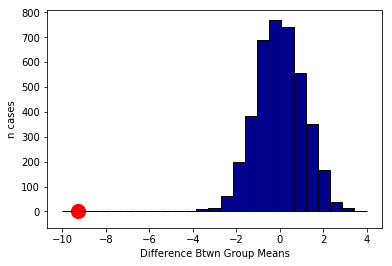

In [22]:
#  plot the outcome. Have the main histogram in darkblue, and put the observed difference on in red.
# set the range for the histogram to be -10,4 with 25 bins
plots.hist(differences, color="darkblue",range=[-10, 4], bins=25)
plots.scatter(observed_difference, 0, color='red', s=200);
plots.xlabel('Difference Btwn Group Means')
plots.ylabel('n cases')

In [23]:
# let's calculate a p value

# first, suppose our Alternative Hypothesis is that the mean of the smokers is lower 
# than that of the non-smokers.  In that case, we need the following expression:
empiricalP_lessthan = np.count_nonzero(differences <= observed_difference) / repetitions
print( "(simulated) P value for mean_smokers <= mean_nonsmokers=",  empiricalP_lessthan)
# this is statistically significant at the 0.01 level

#second, suppose our Alternative Hypoth is that the mean of the smokers is *higher* (>) than that of the smokers.  
# In that case, we need the following expression:
empiricalP_greaterthan = np.count_nonzero(differences > observed_difference) / repetitions
print("(simulated) P value for mean_smokers > mean_nonsmokers=", empiricalP_greaterthan)      
# this is not statistically significant!

# we can do 2 tailed test here, though we need to be careful.  First, we need the p-value that corresponds
# to the *smaller* mass from the above.  That's clearly the first one (<=) since it is 0 (and thus smaller than 1).  
# Then we need to double it.
print( "(simulated) P value for mean_smokers != mean_nonsmokers=",  empiricalP_lessthan*2)

#NB: this is equivalent to taking the bigger one and doing (1-1tail p value)*2 
# which is: (1-empiricalP_greaterthan)*2 = 0 also



(simulated) P value for mean_smokers <= mean_nonsmokers= 0.0
(simulated) P value for mean_smokers > mean_nonsmokers= 1.0
(simulated) P value for mean_smokers != mean_nonsmokers= 0.0
